# Financial Statements Reader - Iteration 1

Long-term Goal:
- Develop a fully automated and modularized algorithm for the extraction of financial data from EDGAR 10-K/10-Q filings
- Volatility analysis of company price based on fundamental factors

Current Progress:
- Database of relevant companies, CIK numbers, symbols, industries, etc
- Fully tuned webscraper for the extraction of 10-Q/10-K PDFs
- Fully automated storage and organization of these PDFs and conversion to PNG images for further analysis
- Extraction of raw 10-Q/10-K with the input of a single SQL query
- Fully automated conversion of company filings to structured data as strings using Google Cloud OCR

# Notable Functions:

#### Stage 1: Scraping Data
- `extract_filings_as_png` : main scraping function that calls all the below helper functions starting with `query_tickers_data`
- `query_tickers_data` : queries database for ticker data
- `scrolling_scraper` : operational scraping function for an edgar webpage
- `open_company_table` : serves as a main scraping function using a companies `cik` and `ticker` to call `scrolling_scraper`
- `convert_company_results` : cleans the results from `open_company_table`
- `iterated_save_webpages_as_pdf` : uses cleaned `company_results` to extract all PDFs from your database query
- `convert_company_filings_folder` : transforms all PDFs from `iterated_save_webpages_as_pdf` to PNG images for analysis

#### Stage 2: Classifying Useful Reports
- `crop_pngs` : crops all PNG images and organizes them in a new folder to be processed by OCR
- `folder_strings` : uses google cloud OCR to convert all PNG images to a dictionary of strings organized by company, filing, and page number
- `classify_important_words` : uses a rule-based system to count number of occurences of important words found manually in reports
- `classify_number_letter_ratio` : calculates the ratio of numbers : letters on a given page for useful analysis
- The remainder of this section was done non-functionally and is still in progress
- Results seem to indicate the need of manual labeling for classification of these images

#### Stage 3: Data Extraction
- Once I am able to correctly classify the pages I need from the filings I plan to train a model on OCR from these key images using data bought from Yahoo finance. This should allow me to extract all necessary historical data.


### Conclusion:
- Fortunately for filings submitted after 2017 I will be able to extract the data using an XBRL parser. 
- I wanted the historical data due to my interest in a volatitlity analysis and improvement in my data engineering skills

#### Imports

In [64]:
# File Organization
import os
import sys
import tempfile
import time
import io
import pickle

# OCR and Image Processing
import pytesseract
import easyocr
from pdf2image import convert_from_path
import cv2
import fitz
from PIL import Image

# Cloud Computing
from google.cloud import vision

# Analysis Tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter
import seaborn as sns

# For Database Queries
import pyodbc
from sqlalchemy import create_engine

# Webscraping
import requests
import selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# PDF Retrieval
import asyncio
from pyppeteer import launch
import nest_asyncio
import pyppdf
from pyppeteer.errors import PageError

# Multi Threading
import concurrent.futures

# NLP Tools
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

# Machine Learning
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

installing pytesseract
https://stackoverflow.com/questions/50951955/pytesseract-tesseractnotfound-error-tesseract-is-not-installed-or-its-not-i

In [ ]:
pytesseract.pytesseract.tesseract_cmd = "C:\\Program Files\\Tesseract-OCR\\tesseract.exe"

In [ ]:
def time_function_execution(func, *args, **kwargs):
    """
    Wrapper function to measure the execution time of a given function.

    Args:
    func (callable): The function to be timed.
    *args: Variable length argument list for the function `func`.
    **kwargs: Arbitrary keyword arguments for the function `func`.

    Returns:
    The result of the function `func` if it returns anything, otherwise None.
    """
    # Check if the func is callable
    if not callable(func):
        raise ValueError(f"The provided argument {func} is not a callable function")

    start_time = time.perf_counter()
    result = func(*args, **kwargs)
    end_time = time.perf_counter()
    duration = end_time - start_time
    print(f"The function '{func.__name__}' took {duration} seconds to complete.")
    
    return result

# Stage 1: Image Data Scraping Pipeline
- Scraping and Storing 10-K/10-Q Image Data

### Step 1: Query Desired Ticker/Cik Data From MS SQL Server

In [2]:
def query_tickers_data(query, ticker=False):
    
    #Define connection string
    connection_string = 'mssql+pyodbc://DESKTOP-FNP14KN\SQLEXPRESS/VolatilityProjectDB?driver=SQL+Server&trusted_connection=yes'
    
    #Create engine
    engine = create_engine(connection_string)
    
    # Query Individual Ticker
    if ticker:
        ticker_query = f"SELECT Symbol, CIK FROM spy500_tickers_df WHERE Symbol = '{ticker}'"
        tickers_df = pd.read_sql_query(ticker_query, engine)
        return tickers_df
    
    # Query All Desired Data
    else:
        multi_query = f"{query}"
        tickers_df = pd.read_sql_query(multi_query, engine)
        return tickers_df

### Step 2: Getting filing data for a company
- Collecting all the links to a company's filings and corresponding filing dates

###### Scraping Errors

In [ ]:
# Defining Error Classes For Scraper

class OpenCompanyTableError(Exception):
    def __init__(self, message, additional_data=None):
        super().__init__(message)
        self.additional_data = additional_data

class TableNumberExtractionError(Exception):
    def __init__(self, message, additional_data=None):
        super().__init__(message)
        self.additional_data = additional_data
        
class TableDataExtractionError(Exception):
    def __init__(self, message, additional_data=None):
        super().__init__(message)
        self.additional_data = additional_data
        
class ScrollingScraperError(Exception):
    def __init__(self, message, additional_data=None):
        super().__init__(message)
        self.additional_data = additional_data

##### Edgar Table Numbers

In [ ]:
# Defining a function to extract table entry numbers

"""
- Start = first shown entry on the page
- Middle = last shown entry on the page
- End = total number of entries on the entire table
- Driver = selenium webdriver
"""
def get_table_numbers(driver):
    try:
        # Getting page numbers
        page_numbers = driver.find_element(By.XPATH, '/html/body/main/div[5]/div/div[3]/div[4]')

        # Extracting page numbers by regex
        scroll_numbers = re.search("^\D*?(\d{1,3})\D+(\d{1,3})\D+(\d{1,3})\D*$", page_numbers.text)
        if scroll_numbers:
            start, middle, end = scroll_numbers.groups()
            return int(start), int(middle), int(end)
        else:
            raise TableNumberExtractionError("Page numbers not found in the expected format.")
    except TableNumberExtractionError as e:
        return str(e)

##### Edgar Table Data

In [ ]:
# Defining a function to scrape the filing data on a particular table

"""
- Takes start and middle to scrape data in the range(start, middle+1)
- Takes selenium webdriver to function
- Takes sets respective to data being to ensure no overlapping entries are scraped
"""

def get_table_data(start, middle, driver, filing_type_set, form_link_set, reporting_date_set):
    try:
        for i in range(start, middle+1):
            #Filing path
            filing_path = f'/html/body/main/div[5]/div/div[3]/div[3]/div[2]/table/tbody/tr[{i}]/td[1]'
            #Form link path
            form_link_path = f'/html/body/main/div[5]/div/div[3]/div[3]/div[2]/table/tbody/tr[{i}]/td[2]/div/a[1]'
            # Reporting date path
            reporting_date_path = f'/html/body/main/div[5]/div/div[3]/div[3]/div[2]/table/tbody/tr[{i}]/td[4]/a'
            # Getting desired elements
            filing = driver.find_element(By.XPATH, filing_path)
            form_link = driver.find_element(By.XPATH, form_link_path)
            reporting_date = driver.find_element(By.XPATH, reporting_date_path)
            # Adding them indexed to set
            filing_type_set.add((i, filing.text))
            form_link_set.add((i, form_link.get_attribute('href')))
            reporting_date_set.add((i, reporting_date.text))
    except TableDataExtractionError as e:
        raise TableDataExtractionError(f"Table data extraction error: {str(e)}")

##### secondary function to execute data retrieval for a given company

In [ ]:
#Defining a function to recursively scroll and scrape all desired data as efficient as possible

"""
- Takes selenium driver to function
- Uses get_table_numbers to evaluate location on page
- Uses get_table_data to extract the data
"""

def scrolling_scraper(driver):
    try:
        # Entering first loop to get initial data
        while True:
            
            #Initializing Empty Sets
            filing_type_set = set()
            form_link_set = set()
            reporting_date_set = set()

            # Defining Table to scroll on
            scrollable_XPATH = '/html/body/main/div[5]/div/div[3]/div[3]/div[2]'
            scrollable_element = driver.find_element(By.XPATH, scrollable_XPATH)

            #Getting initial table numbers
            start, middle, end = get_table_numbers(driver)

            # Scraping initial table data
            get_table_data(start, middle, driver, filing_type_set, form_link_set, reporting_date_set)

            # Scrolling down the default ~32 entries within the element
            driver.execute_script('arguments[0].scrollTop += 1000', scrollable_element)
            
            # Double Checking The Table is Fully Loaded After the First Scroll
            check_start, check_middle, check_end = get_table_numbers(driver)
            
            # Enter the Scraping Loop If the Page is Fully Loaded
            if end == check_end:
                
                # Scraping Loop
                while True:

                    # Getting new_start and new_middle after first scroll
                    new_start, new_middle, new_end = get_table_numbers(driver)

                    # Checking the most common (most optimized) occurence first
                    # Ensures scraping is done completely and optimally
                    if -2<(new_start-middle)<=0:
                        # Best outcome, scrolled perfectly

                        # Take the next iteration of data
                        get_table_data(new_start, new_middle, driver, filing_type_set, form_link_set, reporting_date_set)

                        # Redefine our start and middle points
                        start, middle, end = get_table_numbers(driver)

                        #Scroll down another ~32 entries and restart the loop
                        driver.execute_script('arguments[0].scrollTop += 1000', scrollable_element)

                    # Checking if the algorithm is done scraping (assumes scrolling will be done optimally)
                    elif new_middle == end:
                        # Take the last iteration of data
                        get_table_data(new_start, new_middle, driver, filing_type_set, form_link_set, reporting_date_set)

                        #Break the loop
                        break

                    # Checking if the scrolling is slightly sub-optimal and we are seeing repeating values
                    # If repeating values will scroll up enough so there are none
                    elif -5<(new_start-middle)<=-2:
                        # Close to optimized but scroll down by the overlapping cell count and restart the loop
                        overlapping_cell_count = int(new_start-middle)
                        driver.execute_script(f'arguments[0].scrollTop += {31.0001205*overlapping_cell_count}', scrollable_element)

                    # Checking if the scrolling is missing some data, and we are seeing some values never being shown
                    # Worst case scenario
                    elif (new_start-middle) > 0:
                        # Calculating how many cells it went too far, scroll back up the amount of cells that it missed and restart
                        missed_cell_count = int(new_start-middle)+1
                        driver.execute_script(f'arguments[0].scrollTop -= {31.0001205*missed_cell_count}', scrollable_element)

                    # Checking for errors in the loop
                    else:
                        print((new_start-middle), new_middle, end)
                        raise ScrollingScraperError("Scrolling scraper returned an error in the loop.")
                        break
            
            # Scrolling back up and trying again if the table was not fully loaded
            else:
                driver.execute_script('arguments[0].scrollTop -= 1050', scrollable_element)
                continue
                
            # Breaking the outer loop after scraping
            break
                
                
        # Returning sorted data as a list
        return sorted(list(filing_type_set), key=lambda x: x[0]), sorted(list(reporting_date_set), key=lambda x: x[0]),\
               sorted(list(form_link_set), key=lambda x: x[0])
    
    #Returning any errors
    except TableNumberExtractionError as e:
        raise ScrollingScraperError(f"ScrollingScraperError: {str(e)}")
    except TableDataExtractionError as e:
        raise ScrollingScraperError(f"ScrollingScraperError: {str(e)}")
    except ScrollingScraperError as e:
        raise ScrollingScraperError(f"ScrollingScraperError: {str(e)}")

##### main scraping function for retrieving filing information

In [ ]:
def open_company_table(ticker, cik):
    
    """
    - Essentially the "main" function for the scraper
    - Uses scrolling_scraper as the "secondary main" function
    - Takes cik to locate edgar website
    - Takes ticker mainly for documentation reasons
    
    """
    
    try:
        #Opening webdriver
        driver = webdriver.Chrome()
        driver.get(f"https://www.sec.gov/edgar/browse/?CIK={cik}&owner=exclude")
        driver.maximize_window()

        #Initialize wait
        wait = WebDriverWait(driver, 5)

        #Clicking 10-K/10-Q reports button when ready
        reports_path = '/html/body/main/div[4]/div[2]/div[3]/h5'
        reports_button = wait.until(EC.element_to_be_clickable((By.XPATH, reports_path)))
        reports_button.click()

        #Clicking view_all_button button when ready
        view_all_path = '/html/body/main/div[4]/div[2]/div[3]/div/button[1]'
        view_all_button = wait.until(EC.element_to_be_clickable((By.XPATH, view_all_path)))
        view_all_button.click()

        #Clicking from_date_button when ready and deleting default range
        from_date_button = wait.until(EC.element_to_be_clickable((By.ID, "filingDateFrom")))
        from_date_button.click()

        for _ in range(10):
            from_date_button.send_keys(Keys.BACK_SPACE)

        #Move to the top left corner of the body element and click to refresh the table
        top_left_element = wait.until(EC.element_to_be_clickable((By.TAG_NAME, 'body')))
        actions = ActionChains(driver)
        actions.move_to_element_with_offset(top_left_element, 0, 0).click().perform()
            
        #Perform scrolling scraper
        results = scrolling_scraper(driver)
        
        #Quitting after results are achieved
        driver.quit()
        
        #Returning results along with the ticker and the cik
        return (ticker, cik, results)

    except TableNumberExtractionError as e:
        return f"Error: {e}\nTicker: {ticker}\nCIK: {cik}"
    except TableDataExtractionError as e:
        return f"Error: {e}\nTicker: {ticker}\nCIK: {cik}"
    except ScrollingScraperError as e:
        return f"Error: {e}\nTicker: {ticker}\nCIK: {cik}"
    except OpenCompanyTableError as e:
        return f"Error: {e}\nTicker: {ticker}\nCIK: {cik}"

### Step 3: Cleaning Filing Information

In [ ]:
# Defining Error Classes For Cleaning

class ConvertCompanyResultsError(Exception):
    def __init__(self, message, additional_data=None):
        super().__init__(message)
        self.additional_data = additional_data

##### converting data to pd dataframe and cleaning

In [ ]:
# Writing a function to convert company_results to dataframe object

def convert_company_results(company_results):
    try:
        # Convert the data into a format suitable for DataFrame creation
        converted_data = {f'Column_{i}': {index: value for index, value in sublist} 
                      for i, sublist in enumerate(company_results[2], start=1)}

        # Creating the DataFrame
        df = pd.DataFrame(converted_data).rename(columns={'Column_1':'Form_Type', 'Column_2':'Reporting_Date', 'Column_3':'Form_Link'})

        # Converting links from javascript version to pure html version
        df['Form_Link'] = df['Form_Link'].str.replace('ix?doc=/', '', regex=False)

        # Converting Reporting_Date to datetime
        df['Reporting_Date'] = pd.to_datetime(df['Reporting_Date'])

        # Creating 'access' column based on the year (no pdfs prior to 2001 and later than 2018)
        # some text documents in 2000 might be worth considering
        df['access'] = (df['Reporting_Date'].dt.year >= 2001) & (df['Reporting_Date'].dt.year <= 2018)

        # Creating Column for Company Name For Information Transfer
        df['Ticker_Symbol'] = company_results[0]
        
        # Creating Base Column For If File Exists
        df['File_Exists'] = False
        
        # Fixing 10-K/A type Filings
        df['Form_Type'] = df['Form_Type'].str.replace("/", "", regex=False)

        return df
    except ConvertCompanyResultsError as e:
        return f"Error: {e}\nCompany Results: {company_results}"

### Step 4: Retrieving PDFs for a Company's Filings
- pyppeteer pdf retrieval

In [ ]:
# Defining Error Classes For PDF Retrieval

class SaveWebpageAsPDFError(Exception):
    def __init__(self, message, additional_data=None):
        super().__init__(message)
        self.additional_data = additional_data
        
class SaveChunkError(Exception):
    def __init__(self, message, additional_data=None):
        super().__init__(message)
        self.additional_data = additional_data
        
class IteratedSaveWebpagesAsPDFError(Exception):
    def __init__(self, message, additional_data=None):
        super().__init__(message)
        self.additional_data = additional_data

##### retrieving a single filing as PDF

In [ ]:
async def save_webpage_as_pdf(browser, Form_Link, output_file):
    try:
        page = await browser.newPage()
        # Navigate to page and wait for connection to be idle
        await page.goto(Form_Link, {'waitUntil': 'networkidle0'})  # Waits for the network to be idle (no more network connections for at least 500 ms)
        # Save the page as PDF
        await page.pdf({'path': output_file, 'format': 'A4'})
        # Close browser
        #await browser.close()
    except PageError as e:
        print(f"Error: {e}\nForm_Link: {Form_Link}\nOutput_File_Location: {output_file}")
    finally:
        await page.close()

##### retrieving all filings as PDFs for a company

In [ ]:
# Function to ensure no more than 8 active sessions per second
async def save_chunk(chunk, company_path):
    try:
        # Launch Session
        browser = await launch({'headless': True, 
                                'args': ['--no-sandbox', 
                                            '--disable-setuid-sandbox', 
                                            '--user-agent="pypp"']})
        tasks = [asyncio.create_task(save_webpage_as_pdf(browser, row.Form_Link, os.path.join(company_path, f"{row.Ticker_Symbol}_{row.Form_Type}_{row.Reporting_Date.strftime('%Y-%m-%d')}.pdf"))) for row in chunk.itertuples()]
        await asyncio.gather(*tasks)
        await browser.close()
    except SaveChunkError as e:
        return f"Error: {e}\nFor chunk: {chunk}\nFor path: {company_path}"

# Function to Iterate Over Company Dataframe
async def iterated_save_webpages_as_pdf(df_company, Ticker_Symbol):
    try:
        company_path = f"C:\\Users\\qnpea\\OneDrive\\Desktop\\Fundamental_pdfs\\{Ticker_Symbol}"
        if not os.path.exists(company_path):
            os.makedirs(company_path)
            
        # Filter the DF For Desired Rows
        filtered_df = df_company[(df_company['access']) & (df_company['File_Exists'] == False)]

        # Split Into Chunks of 8
        chunks = [filtered_df.iloc[i:i + 8] for i in range(0, len(filtered_df), 8)]

        for chunk in chunks:
            await save_chunk(chunk, company_path)
            # Sleep to ensure not more than 8 operations per second
            await asyncio.sleep(0.5)
    except IteratedSaveWebpagesAsPDFError as e:
        return f"Error: {e}\ndf_company: {df_company}\nTicker_Symbol: {Ticker_Symbol}"

### Step 4: Converting PDF Filing to PNG Files for OCR

In [ ]:
# Defining Error Classes For Converting PDFs to Images

class ConvertPDFToImgError(Exception):
    def __init__(self, message, additional_data=None):
        super().__init__(message)
        self.additional_data = additional_data
        
class FailedToDeleteConvertPdfToImgError(Exception):
    def __init__(self, message, additional_data=None):
        super().__init__(message)
        self.additional_data = additional_data
        
class ConvertCompanyFilingsFolderError(Exception):
    def __init__(self, message, additional_data=None):
        super().__init__(message)
        self.additional_data = additional_data

##### converting 1 pdf to png
- conversion and file organization

In [ ]:
#convert_pdf_to_img

#pdf_path is the original file being converted
#final_path is the new path to the converted file
#company_path is the folder for all company filings

#Fundamental Images is default path
#Check if company folder exists, if it does access company folder. If it doesn't write company folder.
#Check if Date + Form Name Folder in Company folder exists. If it doesn't write Date + Form name folder

def convert_pdf_to_img(pdf_path, company_name, date, form_name, overwrite=True):
    try:
        #Setting Image Quality
        dpi = 300
        zoom = dpi / 72
        mat = fitz.Matrix(zoom, zoom)

        #Opening Doc
        doc = fitz.open(pdf_path)

        company_path = f"C:\\Users\\qnpea\\OneDrive\\Desktop\\Fundamental_Images\\{company_name}"
        final_path = f"C:\\Users\\qnpea\\OneDrive\\Desktop\\Fundamental_Images\\{company_name}\\{company_name}_{form_name}_{date}"

        #Checking if the appropriate folder already exists, if overwrite = True converting images again
        if os.path.exists(final_path) and overwrite==True:
            for page in doc:
                pix = page.get_pixmap(matrix=mat)
                pix.save(f"{final_path}\\{company_name}_{form_name}_{date}-%i.png" % page.number)

        #If appropriate folder already exists and overwrite = False
        elif os.path.exists(final_path) and overwrite==False:
            print(f"Path exists for: {company_name}_{form_name}_{date}. But overwrite was set to false.")

        #If company_name folder exists, making final_path and converting images
        elif os.path.exists(company_path):
            os.makedirs(final_path)
            for page in doc:
                pix = page.get_pixmap(matrix=mat)
                pix.save(f"{final_path}\\{company_name}_{form_name}_{date}-%i.png" % page.number)

        #If neither exist, making company_name folder, final_path folder, and converting images
        else:
            os.makedirs(company_path)
            os.makedirs(final_path)
            for page in doc:
                pix = page.get_pixmap(matrix=mat)
                pix.save(f"{final_path}\\{company_name}_{form_name}_{date}-%i.png" % page.number)

        #CLose and Delete The File When Done
        try:
            doc.close()
            os.remove(pdf_path)
        except FailedToDeleteConvertPdfToImgError as e:
            return f"Failed to delete {pdf_path}, error: {e}"
    except ConvertPDFToImgError as e:
        return f"Error: {e}, PDF Path: {pdf_path}\n company_name: {company_name}\n date: {date}\n form_name: {form_name}\n overwrite: {overwrite}"

##### Main Function to convert entire company folder of PDF Filings to PNG Images in New Directory
- uses convert_pdf_to_png() for all pdfs of a company
- uses multithreading to expedite process

In [ ]:
def convert_company_filings_folder(company_filings_pdfs_folder_path, overwrite=True):
    try:
        if not os.path.exists(company_filings_pdfs_folder_path):
            return "False"

        with concurrent.futures.ThreadPoolExecutor(max_workers=12) as executor:
            futures = []
            for pdf_path in os.listdir(company_filings_pdfs_folder_path):
                # Extracting Information from PDF Location
                company_name, form_name, date = pdf_path.replace('.pdf', '').split('_')
                # Naming the Final Path of the given PDF
                final_pdf_path = os.path.join(company_filings_pdfs_folder_path, pdf_path)

                # Implementing Multi Threading
                future = executor.submit(convert_pdf_to_img, final_pdf_path, company_name, date, form_name, overwrite)
                futures.append(future)

            # Wait for all futures to complete
            concurrent.futures.wait(futures)
    except ConvertCompanyFilingsFolderError as e:
        f"Error: {e}\n Company Filings PDFs Folder Path: {company_filings_pdfs_folder_path}\n Overwrite: {overwrite}"
        

### Final Step: Defining Main Data Scraping Pipeline Function
- 1. Takes (optional) SQL Query to select desired tickers
- 2. Gets filing data for all selected companies
- 3. Retrieves PDFs for all filings organized by company
- 4. Converts all PDFs filings to PNG images organized by company, filing, and date

In [ ]:
# Defining Error Classes For Main Scraping Functions

class ExtractorError(Exception):
    def __init__(self, message, additional_data=None):
        super().__init__(message)
        self.additional_data = additional_data
        
class ExtractFilingsAsPngError(Exception):
    def __init__(self, message, additional_data=None):
        super().__init__(message)
        self.additional_data = additional_data

##### checks if the file already exists before extracting pdf

In [ ]:
# Function to Check If A Filing Has Already Been Extracted as PNGs

# Cleaning of 10-K/A forms needs to be address
# Issue of single company with multiple tickers needs to be addressed

def png_checker(cleaned_company_results, ticker):
    for i, row in cleaned_company_results.iterrows():
        try:
            check_path = f"C:\\Users\\qnpea\\OneDrive\\Desktop\\Fundamental_Images\\{ticker}\\{ticker}_{row[0]}_{row[1].strftime('%Y-%m-%d')}"
            size = os.stat(check_path).st_size

            # Checking Condition Where File is Empty
            if os.stat(check_path).st_size > 0:
                cleaned_company_results.at[i, 'File_Exists'] = True
        
        # Checking Condition Where File Does Not Exist
        except FileNotFoundError:
            continue
        
    return cleaned_company_results

##### helper function for execution of main

In [ ]:
# Helper Function for The Main Scraping Function

async def extractor(tickers_df, overwrite):
    try:
        for i, row in tickers_df.iterrows():
            ticker = row["Symbol"]
            cik = row["CIK"]
            try:
                company_results = open_company_table(ticker, cik)
                cleaned_company_results = convert_company_results(company_results)
                checked_company_results = png_checker(cleaned_company_results, ticker)
                await iterated_save_webpages_as_pdf(checked_company_results, ticker)
                company_path = f"C:\\Users\\qnpea\\OneDrive\\Desktop\\Fundamental_pdfs\\{ticker}"
                convert_company_filings_folder(company_path, overwrite)
            except ExtractorError as e:
                return f"error: {e} for {row} in {ticker}"
                pass
    except ExtractorError as e:
        return(f"error: {e} for {tickers_df}")
    return f"Done: {tickers_df}"

##### main function for querying png file data

In [ ]:
# Main Function for Extracting Filings as PNG Files

async def extract_filings_as_png(overwrite=False):
    try:
        nest_asyncio.apply()
        print("For iterated extractions input SQL-query from tickers datebase. For singular return input company ticker symbol. For manual input, input 'manual' for a reprompt.")
        response = input("Input: ")

        # Single ticker response
        if response.isalpha():
            ticker = response
            ticker_df = query_tickers_data(query=False, ticker=ticker)
            await extractor(ticker_df, overwrite=True)

        # Manual response (Incomplete)
        elif response.lower() == "manual":
            ticker = input("Input ticker symbol: ")
            cik = input("Input cik number: ")
            company_results = open_company_table(ticker, cik)
            df_results = convert_company_results(company_results)

        # Standard query response
        else:
            tickers_df = query_tickers_data(query=response)
            await extractor(tickers_df, overwrite)
    except ExtractFilingsAsPngError as e:
        return(f"error: {e}, overwrite {overwrite}")

### Scraping Processing Time Future Improvements:
- Check directory with "overwrite" function before scraping pdfs
- Only scrape the dates that I need (easy fix)
- Address the bug for when the table doesn't load on EDGAR
- Address the issue for companies with multiple ticker symbols (BRK and Google)

In [ ]:
# Sample tickers_query = "SELECT TOP 25 Symbol, Security, Sector, CIK FROM spy500_tickers_df"
# Google is bugged (maybe because it has 2 tickers GOOGL and GOOG)
# test --> SELECT Symbol, CIK FROM spy500_tickers_df WHERE CIK = '1652044'
await extract_filings_as_png(overwrite=False)

# Stage 2: Classifying Useful Reports
- Balance Sheet
- Income Statement
- Cashflow Statement

### Step 1: Image Preprocessing
- Make temporary folder containing preprocessed images (only 1/3 of the page)
- Speeds up processing time and removes unneccessary data

In [ ]:
# Defining Error Classes For Image Pre-processing

class CropPercentError(Exception):
    def __init__(self, message, additional_data=None):
        super().__init__(message)
        self.additional_data = additional_data

class CropWhiteSpaceError(Exception):
    def __init__(self, message, additional_data=None):
        super().__init__(message)
        self.additional_data = additional_data
        
class CropFilingError(Exception):
    def __init__(self, message, additional_data=None):
        super().__init__(message)
        self.additional_data = additional_data
        
class CropCompanyError(Exception):
    def __init__(self, message, additional_data=None):
        super().__init__(message)
        self.additional_data = additional_data
        
class CropPngsError(Exception):
    def __init__(self, message, additional_data=None):
        super().__init__(message)
        self.additional_data = additional_data

In [ ]:
# Cropping 1 png image

def crop_percent(image_path, output_path, processed_directory_path,
                 upper_percent=0.00, lower_percent=0.00, both_percent=False):
    """
    - Crops the top and/or bottom (percentage %) of the image.
    - Defaults to 0 percent.

    Args:
    image_path (str): Path to the input image.
    output_path (str): Path for saving the cropped image.
    processed_directory_path (str) : Directory for filing
    upper_percent (float): Percentage to crop off the top of the image.
    lower_percent (float): Percentage to crop off the bottom of the image.
    both_percent (float): Percentage to crop off the bottom and top equally.
    """
    try:
        with Image.open(image_path) as img:
            
            # Get img size
            width, height = img.size
            
            if both_percent == False:
                
                """
                Need to review crop_upper, crop_lower logic
                """
                
                # Upper bound is the height * (upper_percent)
                crop_upper = height * upper_percent
                
                # Lower bound is the height * (complement of lower_percent)
                crop_lower = height * (1-lower_percent)
                
                # Define the box to crop (left, upper, right, lower)
                box = (0, crop_upper, width, crop_lower)
                
            else:
                
                # Calculate the crop height
                crop_height = height * percent
                
                # Define the box to crop (left, upper, right, lower)
                box = (0, crop_height, width, height - crop_height)

            # Crop the image    
            cropped_img = img.crop(box)
            
            # Save it if directory exists
            if os.path.exists(processed_directory_path):
                cropped_img.save(output_path)
                
            # Make directory if it does not exist and save
            else:
                os.mkdir(processed_directory_path)
                cropped_img.save(output_path)
            
    except CropPercentError as e:
        return f"Error: {e} for path {image_path}"

In [ ]:
# Cropping entire company filing folder with pngs ~40-200 images long

def crop_filing(company_filing_path, upper_percent, lower_percent, both_percent):
    try:
        # Making new folder with cropped images
        # Multi-threading on the image-level
        company_filing_path_processed = company_filing_path.replace('Fundamental_Images', 'Fundamental_Images_Processed')
        with concurrent.futures.ThreadPoolExecutor(max_workers=12) as executor:
            futures = []
            for item in os.listdir(company_filing_path):
                future = executor.submit(crop_percent, image_path = f"{company_filing_path}\\{item}", 
                             output_path = f"{company_filing_path_processed}\\{item}",
                             processed_directory_path = company_filing_path_processed,
                             upper_percent = upper_percent,
                             lower_percent = lower_percent,
                             both_percent = both_percent)
                futures.append(future)
                
            #Wait for all futures to complete
            concurrent.futures.wait(futures)
            
    except FileNotFoundError:
        print(f"No such directory: {company_filing_path}")
    except PermissionError:
        print(f"Permission denied: {company_filing_path}")
    except OSError as error:
        print(f"Error accessing {company_filing_path}: {error}")
    except CropFilingError as e:
        print(f"Error: {e} for path {company_filing_path}")
    
    # Complete Statement
    print(f"Filing: {company_filing_path} complete")

In [ ]:
def crop_company(company_path, upper_percent, lower_percent, both_percent):
    try:
        for filing in os.listdir(company_path):
            company_filing_path = os.path.join(company_path, filing)
            crop_filing(company_filing_path, upper_percent, lower_percent, both_percent)
    except FileNotFoundError:
        print(f"No such directory: {company_path}")
    except PermissionError:
        print(f"Permission denied: {company_path}")
    except OSError as error:
        print(f"Error accessing {company_path}: {error}")
    except CropCompanyError as e:
        print(f"Error: {e} for path {company_path}") 

In [ ]:
# Cropping entire Fundamental_Images Folder

# Images_Folder -> Company_Folder -> Filings_Folder -> PNGs of Filing

"""
Later will implement way to ensure overwriting does not occur unless desired
For now overwriting will always occur
company_path_processed = company_path.replace('Fundamental_Images', 'Fundamental_Images_Processed')
"""

def crop_pngs(upper_percent = 0.00, lower_percent = 0.00, both_percent = False):
    try:
        base_path = r'C:\Users\qnpea\OneDrive\Desktop\Fundamental_Images'
        base_processed_path = r'C:\Users\qnpea\OneDrive\Desktop\Fundamental_Images_Processed'
        
        # Iterating through companies in the directory
        for company in os.listdir(base_path):
            company_path = os.path.join(base_path, company)
            
            # Checking if folder exists in Fundamental_Images_Processed
            if not os.path.exists(os.path.join(base_processed_path, company)):
                os.mkdir(os.path.join(base_processed_path, company))
            crop_company(company_path, upper_percent, lower_percent, both_percent)
                
    except CropFilingError as e:
        print(f"Error: {e}")
        
    print("Cropping PNGs Complete")

In [ ]:
crop_pngs(upper_percent = 0.02, lower_percent = 0.64)

In [ ]:
company_filing_path = r"C:\Users\qnpea\OneDrive\Desktop\Fundamental_Images\AMZN\AMZN_10-K_2002-12-31"
company_filing_path_processed = company_filing_path.replace('Fundamental_Images', 'Fundamental_Images_Processed')
split

### Step 2: Extracting Text Data Using OCR

In [ ]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"C:\Users\qnpea\OneDrive\Desktop\Google Cloud\Service-Account\long-equinox-414900-f6e0dc35fab6.json"

##### Future Improvements
- Save output incrementally (10%, 20%, 25%, etc way through the process) instead of 1 big file
- Use print statements to log progress
- Use batching to improve processing speed

In [ ]:
def filing_strings_google_cloud(filing_directory):
    # Instantiate a Vision API client
    client = vision.ImageAnnotatorClient()
    
    text_list = []
    if not os.path.exists(filing_directory):
        print(f"The directory {filing_directory} does not exist")
        return []
    
    for entry in os.listdir(filing_directory):
        try:
            # Assuming the file naming includes page numbers as in the original function
            page_num = int(entry.split("-")[4].split(".")[0])
            full_path = os.path.join(filing_directory, entry)
            
            # Read the image content
            with io.open(full_path, 'rb') as image_file:
                content = image_file.read()
            image = vision.Image(content=content)
            
            # Perform text detection
            response = client.document_text_detection(image=image)
            text = response.full_text_annotation.text
            
            text_list.append((page_num, text))
        
        except Exception as e:
            print(f"An error occurred with {entry}: {e}")
    
    # Sort and return the list of texts by page number
    return sorted(text_list, key=lambda x: x[0])

In [ ]:
def company_strings_google_cloud(company_directory):
    try:
        filings_dict = {}
        for filing in os.listdir(company_directory):
            filing_path = os.path.join(company_directory, filing)
            if os.path.isdir(filing_path):
            # Calling the OCR function and storing the result in the dictionary
                filings_dict[filing] = filing_strings_google_cloud(filing_path)
                
        return filings_dict
                
    except Exception as e:
        print(f"An error occurred with {company}: {e}")

In [ ]:
def folder_strings(main_directory):
    try:
        company_dict = {}
        for company in os.listdir(main_directory):
            company_path = os.path.join(main_directory, company)
            if os.path.isdir(company_path):
            # Calling the OCR function and storing the result in the dictionary
                company_dict[company] = company_strings_google_cloud(company_path)
        return company_dict
            
    except Exception as e:
        print(f"An error occurred with {company}: {e}")

In [ ]:
# Output

images_processed = r"C:\Users\qnpea\OneDrive\Desktop\Fundamental_Images_Processed"

In [ ]:
# Result

folder_strings(images_processed)

### Saving Results

In [ ]:
result = _

# Cache the dictionary to a pickle file
with open('processed_strings.pkl', 'wb') as f:
    pickle.dump(result, f)

## Opening Results
- processed_strings structure: nested_dictionary
- level 1: Companies 
- level 2: Filings (dictionary)
- level 3: List of tuples (page number, string)

##### Results Metrics:
- 26 companies
- 1575 filings 
- 96151 unique images 
- ~60 filings per company
- ~61 pages per filing
- ~3,700 pages per company
- ~18 hours of processing time / ~$142 using google cloud

In [3]:
# Opening cached pickle file

with open('processed_strings.pkl', 'rb') as f:
    processed_strings = pickle.load(f)

In [4]:
# Counting Number of Images

y = 0
for key in processed_strings.keys():
    for key2 in processed_strings[key].keys():
        y += len(processed_strings[key][key2])
print(f"Number of pages: {y}")

Number of pages: 96151


In [5]:
# Counting number of filings
print(f"Number of filings: {sum(len(v) for v in processed_strings.values())}")

Number of filings: 1575


### Step 3: Developing a rule-based system & using NLP for PNG labeling

processed_strings = {'Company_Name' : {'Filing_Name' : [(Page_Number, Text)] } }

In [8]:
# Initialize an empty list to hold the data
data_for_df = []

# Iterate through processed_strings (nested dictionary) to extract the information
for company_name, filings in processed_strings.items():
    for filing_name, page_info in filings.items():
        for page_number, text in page_info:
            data_for_df.append({
                "Company": company_name,
                "Filing": filing_name,
                "Page_Number": page_number,
                "Text": text
            })
            
# Convert the list of dictionaries to a DataFrame
df_strings = pd.DataFrame(data_for_df)

# Dropping "GOOG" due to redundency
df_strings = df_strings.loc[df_strings['Company'] != 'GOOG']

# Extracting the Year
df_strings['Year'] = df_strings['Filing'].apply(lambda x: x.split('_')[-1].split('-')[0])

# Fixing the text
df_strings['Text'] = df_strings['Text'].apply(lambda x: x.replace('\n', ' '))

df_strings.head()

,Company,Filing,Page_Number,Text,Year
0,AAPL,AAPL_10-KA_2009-09-26,0,Table of Contents UNITED STATES SECURITIES AND...,2009
1,AAPL,AAPL_10-KA_2009-09-26,1,Yes No The aggregate market value of the votin...,2009
2,AAPL,AAPL_10-KA_2009-09-26,2,Table of Contents Parts of this Amendment No. ...,2009
3,AAPL,AAPL_10-KA_2009-09-26,3,"Table of Contents September 26, 2009, the revi...",2009
4,AAPL,AAPL_10-KA_2009-09-26,4,Table of Contents PART II Item 6. Selected Fin...,2009


In [9]:
df_strings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95189 entries, 0 to 96150
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Company      95189 non-null  object
 1   Filing       95189 non-null  object
 2   Page_Number  95189 non-null  int64 
 3   Text         95189 non-null  object
 4   Year         95189 non-null  object
dtypes: int64(1), object(4)
memory usage: 4.4+ MB


##### Improvements:
- Use a scoring based system to help identify important results

In [11]:
def classify_income_statement(filing):
    
    # Dictionary mapping patterns to their return values
    rules = {
        "statements of operations": "Operations",
        "cost of sales": "CostOfSales",
        "statement of income": "IncomeStatement",
        "statements of comprehensive income": "ComprehensiveIncome",
        "statements of income": "IncomeStatement",
        "net income": "NetIncome",
        "per share": "PerShare",
        "income before tax": "IncomeBeforeTax",
        "gross profit": "GrossProfit",
        "gross margin": "GrossMargin",
        "net sales": "NetSales",
        "revenue": "Revenue",
        "cost of revenue": "CostOfRevenue",
        "consolidated statements of income": "ConsolidatedStatementsOfIncome",
        "consolidated statements of operations": "ConsolidatedStatementsOfOperations",
        "operating income": "OperatingIncome",
        "basic net income per share": "BasicNetIncomePerShare",
        "diluted net income per share": "DilutedNetIncomePerShare",
        "net revenue": "Net Revenue",
        "dividends paid": "DividendsPaid",
        "other income": "OtherIncome",
        "condensed": "Condensed",
            }
    
    # List to hold the results of matched rules
    results = []
    
    for page_tuple in filing:
        page_number = page_tuple[0]
        page_string = page_tuple[1].lower()
    
        # Iterate through each rule and check for matches
        matches = []
        
        for pattern, value in rules.items():
            if pattern in page_string:
                matches.append(value)
                
        if matches:          
            results.append((page_number, matches))
    
    return results

In [12]:
def classify_balance_sheet(filing):
    
    # Dictionary mapping patterns to their return values
    rules = {
        "current assets": "CurrentAssets",
        "cash and cash equivalents": "CashAndCashEquivalents",
        "accounts receivable": "AccountsReceivable",
        "balance sheet": "BalanceSheet",
        "consolidated balance sheets": "ConsolidatedBalanceSheets",
        "inventories": "Inventories",
        "in millions": "InMillions",
        "total assets": "TotalAssets",
        "current liabilities": "CurrentLiabilities",
        "accounts payable": "AccountsPayable",
        "deferred revenue": "Deferred Revenue",
        "long-term debt": "Long-termDebt",
        "total liabilities": "TotalLiabilities",
        "shareholders' equity": "Shareholders'Equity",
        "total liabilities and shareholders' equity": "TotalLiabilitiesAndShareholders'Equity",
        "retained earnings": "RetainedEarnings",
        "other liabilities": "OtherLiabilities",
        "accrued litigation": "AccruedLitigation",
        "assets": "Assets",
        "deferred tax assets": "DeferredTaxAssets",
        "other income": "OtherIncome",
        "total current assets": "TotalCurrentAssets",
        "goodwill": "Goodwill",
        "intangible assets": "IntangibleAssets",
        "deferred": "Deferred",
        "investment securities": "InvestmentSecurities",
        "loans": "Loans",
        "unearned revenue": "UnearnedRevenue",
        "short-term investments": "Short-termInvestments",
        "stockholders' equity": "Stockholders'Equity",
        "common stock": "CommonStock",
            }
    
    # List to hold the results of matched rules
    results = []
    
    for page_tuple in filing:
        page_number = page_tuple[0]
        page_string = page_tuple[1].lower()
    
        # Iterate through each rule and check for matches
        matches = []
        
        for pattern, value in rules.items():
            if pattern in page_string:
                matches.append(value)
                
        if matches:          
            results.append((page_number, matches))
    
    return results

In [15]:
def classify_cash_flows_statement(text):
    
    # Dictionary mapping patterns to their return values
    rules = {
        "net income": "NetIncome",
        "net cash": "NetCash",
        "deferred": "Deferred",
        "cash flows statements": "CashFlowsStatements",
        "net cash from operations": "NetCashFromOperations",
        "financing": "Financing",
        "net cash used": "NetCashUsed",
        "short-term debt": "Short-termDebt",
        "common stock issued": "CommonStockIssued",
        "common stock repruchased": "CommonStockRepruchased",
        "common stock cash": "CommonStockCash",
        "dividends": "Dividends",
        "property and equipment": "PropertyAndEquipment",
        "effect of exchange rates": "EffectOfExchangeRates",
        "cash and cash equivalents": "CashAndCashEquivalents",
        "beginning of period": "BeginningOfPeriod",
        "in millions": "InMillions",
        "cash flows": "CashFlows",
        "condensed consolidated": "CondensedConsolidated",
        "depreciation": "Depreciation",
        "amortization": "Amortization",
        "cash generated": "CashGenerated",
        "cash paid for": "CashPaidFor",
        "inventories": "Inventories",
        "net earnings": "NetEarnings",
        "statements of cash flows": "StatementsOfCashFlows",
        "statements of": "StatementsOf",
        "other current": "OtherCurrent",
        "assets": "Assets",
        "liabilities": "Liabilities",
        "other comprehensive income" :"OtherComprehensiveIncome",
        "net change" : "NetChange",
        "change in net" :"ChangeInNet",
        "comprehensive income" :"ComprehensiveIncome",
            }
    
    # List to hold the results of matched rules
    results = []
    
    # Iterating Through Pages
    for page_tuple in filing:
        page_number = page_tuple[0]
        page_string = page_tuple[1].lower()
        
        # Iterate through each rule and check for matches
        matches = []
        
        # Matching Pattern for each string
        for pattern, value in rules.items():
            if pattern in page_string:
                matches.append(value)
                
        if matches:          
            results.append((page_number, matches))
    
    return results

In [16]:
def classify_number_letter_ratio(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Count the number of digits and alphabetic characters
    number_count = sum(c.isdigit() for c in text)
    alpha_count = sum(c.isalpha() for c in text)
        
    # Calculate the ratio, handling the case where alpha_count is 0
    number_letter_ratio = (number_count / alpha_count) if alpha_count != 0 else 0
        
    return number_letter_ratio

In [17]:
# Update the function to count matches for each rule and return a dictionary
def classify_important_words(row):
    
    rules = {
    "net income": "NetIncome",
    "net cash": "NetCash",
    "deferred": "Deferred",
    "cash flows statements": "CashFlowsStatements",
    "net cash from operations": "NetCashFromOperations",
    "financing": "Financing",
    "net cash used": "NetCashUsed",
    "short-term debt": "Short-termDebt",
    "common stock issued": "CommonStockIssued",
    "common stock repruchased": "CommonStockRepruchased",
    "common stock cash": "CommonStockCash",
    "dividends": "Dividends",
    "property and equipment": "PropertyAndEquipment",
    "effect of exchange rates": "EffectOfExchangeRates",
    "cash and cash equivalents": "CashAndCashEquivalents",
    "beginning of period": "BeginningOfPeriod",
    "in millions": "InMillions",
    "cash flows": "CashFlows",
    "condensed consolidated": "CondensedConsolidated",
    "depreciation": "Depreciation",
    "amortization": "Amortization",
    "cash generated": "CashGenerated",
    "cash paid for": "CashPaidFor",
    "inventories": "Inventories",
    "net earnings": "NetEarnings",
    "statements of cash flows": "StatementsOfCashFlows",
    "other current": "OtherCurrent",
    "assets": "Assets",
    "liabilities": "Liabilities",
    "other comprehensive income": "OtherComprehensiveIncome",
    "net change": "NetChange",
    "change in net": "ChangeInNet",
    "comprehensive income": "ComprehensiveIncome",
    "current assets": "CurrentAssets",
    "accounts receivable": "AccountsReceivable",
    "balance sheet": "BalanceSheet",
    "consolidated balance sheets": "ConsolidatedBalanceSheets",
    "total assets": "TotalAssets",
    "current liabilities": "CurrentLiabilities",
    "accounts payable": "AccountsPayable",
    "deferred revenue": "DeferredRevenue",
    "long-term debt": "Long-termDebt",
    "total liabilities": "TotalLiabilities",
    "shareholders' equity": "Shareholders'Equity",
    "total liabilities and shareholders' equity": "TotalLiabilitiesAndShareholders'Equity",
    "retained earnings": "RetainedEarnings",
    "other liabilities": "OtherLiabilities",
    "accrued litigation": "AccruedLitigation",
    "deferred tax assets": "DeferredTaxAssets",
    "other income": "OtherIncome",
    "total current assets": "TotalCurrentAssets",
    "goodwill": "Goodwill",
    "intangible assets": "IntangibleAssets",
    "investment securities": "InvestmentSecurities",
    "loans": "Loans",
    "unearned revenue": "UnearnedRevenue",
    "short-term investments": "Short-termInvestments",
    "stockholders' equity": "Stockholders'Equity",
    "common stock": "CommonStock",
    "statements of operations": "Operations",
    "cost of sales": "CostOfSales",
    "statement of income": "IncomeStatement",
    "statements of comprehensive income": "ComprehensiveIncome",
    "per share": "PerShare",
    "income before tax": "IncomeBeforeTax",
    "gross profit": "GrossProfit",
    "gross margin": "GrossMargin",
    "net sales": "NetSales",
    "revenue": "Revenue",
    "cost of revenue": "CostOfRevenue",
    "consolidated statements of income": "ConsolidatedStatementsOfIncome",
    "consolidated statements of operations": "ConsolidatedStatementsOfOperations",
    "operating income": "OperatingIncome",
    "basic net income per share": "BasicNetIncomePerShare",
    "diluted net income per share": "DilutedNetIncomePerShare",
    "net revenue": "NetRevenue",
    "dividends paid": "DividendsPaid",
    "condensed": "Condensed"
            }
    
    # Lowercase for rules
    page_string = row['Text'].lower()
    
    # Initialize a counter for all rules set to 0
    rule_counts = {rule: 0 for rule in rules.values()}
    
    # Count occurrences of each pattern in the text
    counts = Counter([value for pattern, value in rules.items() if pattern in page_string])
    
    # Update the rule_counts dictionary with the actual counts
    rule_counts.update(counts)
    
    return rule_counts

##### Applying rules to dataframe

In [18]:
rules = {
    "net income": "NetIncome",
    "net cash": "NetCash",
    "deferred": "Deferred",
    "cash flows statements": "CashFlowsStatements",
    "net cash from operations": "NetCashFromOperations",
    "financing": "Financing",
    "net cash used": "NetCashUsed",
    "short-term debt": "Short-termDebt",
    "common stock issued": "CommonStockIssued",
    "common stock repruchased": "CommonStockRepruchased",
    "common stock cash": "CommonStockCash",
    "dividends": "Dividends",
    "property and equipment": "PropertyAndEquipment",
    "effect of exchange rates": "EffectOfExchangeRates",
    "cash and cash equivalents": "CashAndCashEquivalents",
    "beginning of period": "BeginningOfPeriod",
    "in millions": "InMillions",
    "cash flows": "CashFlows",
    "condensed consolidated": "CondensedConsolidated",
    "depreciation": "Depreciation",
    "amortization": "Amortization",
    "cash generated": "CashGenerated",
    "cash paid for": "CashPaidFor",
    "inventories": "Inventories",
    "net earnings": "NetEarnings",
    "statements of cash flows": "StatementsOfCashFlows",
    "other current": "OtherCurrent",
    "assets": "Assets",
    "liabilities": "Liabilities",
    "other comprehensive income": "OtherComprehensiveIncome",
    "net change": "NetChange",
    "change in net": "ChangeInNet",
    "comprehensive income": "ComprehensiveIncome",
    "current assets": "CurrentAssets",
    "accounts receivable": "AccountsReceivable",
    "balance sheet": "BalanceSheet",
    "consolidated balance sheets": "ConsolidatedBalanceSheets",
    "total assets": "TotalAssets",
    "current liabilities": "CurrentLiabilities",
    "accounts payable": "AccountsPayable",
    "deferred revenue": "DeferredRevenue",
    "long-term debt": "Long-termDebt",
    "total liabilities": "TotalLiabilities",
    "shareholders' equity": "Shareholders'Equity",
    "total liabilities and shareholders' equity": "TotalLiabilitiesAndShareholders'Equity",
    "retained earnings": "RetainedEarnings",
    "other liabilities": "OtherLiabilities",
    "accrued litigation": "AccruedLitigation",
    "deferred tax assets": "DeferredTaxAssets",
    "other income": "OtherIncome",
    "total current assets": "TotalCurrentAssets",
    "goodwill": "Goodwill",
    "intangible assets": "IntangibleAssets",
    "investment securities": "InvestmentSecurities",
    "loans": "Loans",
    "unearned revenue": "UnearnedRevenue",
    "short-term investments": "Short-termInvestments",
    "stockholders' equity": "Stockholders'Equity",
    "common stock": "CommonStock",
    "statements of operations": "Operations",
    "cost of sales": "CostOfSales",
    "statement of income": "IncomeStatement",
    "statements of comprehensive income": "ComprehensiveIncome",
    "per share": "PerShare",
    "income before tax": "IncomeBeforeTax",
    "gross profit": "GrossProfit",
    "gross margin": "GrossMargin",
    "net sales": "NetSales",
    "revenue": "Revenue",
    "cost of revenue": "CostOfRevenue",
    "consolidated statements of income": "ConsolidatedStatementsOfIncome",
    "consolidated statements of operations": "ConsolidatedStatementsOfOperations",
    "operating income": "OperatingIncome",
    "basic net income per share": "BasicNetIncomePerShare",
    "diluted net income per share": "DilutedNetIncomePerShare",
    "net revenue": "NetRevenue",
    "dividends paid": "DividendsPaid",
    "condensed": "Condensed"
            }

In [21]:
unique_rules = [rules.values()]
print(f"Number of rules {len(rules)}")

Number of rules 78


In [20]:
# Applying NumberLetterRatio
df_strings['NumberLetterRatio'] = df_strings['Text'].apply(classify_number_letter_ratio)

In [22]:
# Initializing rules in DF
for rule in rules.values():
    df_strings[rule] = 0

# Applying rule counts to the dataframe
for index, row in df_strings.iterrows():
    counts = classify_important_words(row)
    for rule, count in counts.items():
        df_strings.at[index, rule] = count

In [23]:
# Creating a column for TotalRuleCount
df_strings['TotalRuleCounts'] = df_strings[list(rules.values())].sum(axis=1)

# Moving "TotalRuleCounts" to the 7th position
col = df_strings.pop('TotalRuleCounts')
df_strings.insert(6, 'TotalRuleCounts', col)

#### Selecting a subset based on rules based classification

In [24]:
df_filtered = df_strings[(df_strings['NumberLetterRatio'] > .14) & (df_strings['TotalRuleCounts'] >= 4)]
print(f"Potential Candidates per filing: {df_filtered.groupby('Filing').size().mean()}")

Potential Candidates per filing: 7.518392370572207


### Step 4: Analyzing subset candidates from rules results and some NLP

In [25]:
df_subset = df_filtered.copy()

##### Removing Company Names From Text for NLP:

In [27]:
# Removing companies from text

tickers_data = query_tickers_data("SELECT TOP 25 Company FROM spy500_tickers_df")

In [28]:
# Getting fixed company names
companies_fixed = []
for company in tickers_data['Company'].tolist():
    company_fixed = company.replace(".", "").replace(".", "").replace("Class A", "").replace("Class B", "").replace("Inc, ", "").replace("Inc", "").replace("Corp", "").replace("com", "").replace(" & Co", "").replace("Company", "").replace("Class C", "").replace(",", "").replace(" orporated", "").replace(" oration", "").rstrip()
    companies_fixed.append(company_fixed)
    
companies_fixed.append("Facebook")

# regex pattern
pattern = r'\b(' + '|'.join(re.escape(name) for name in companies_fixed) + r')\b'

In [29]:
# Scrubbing company names from text
df_subset['Text'] = df_subset['Text'].replace(pattern, '', regex=True)

In [37]:
# Removing numbers from text
df_subset['Text'] = df_subset['Text'].str.replace('\d+', '', regex=True)

In [38]:
df_subset['Text']

16       Table of Contents The Company's Other Segments...
23       Table of Contents Current assets: Deferred tax...
24       Table of Contents Three years ended September ...
25       Table of Contents CONSOLIDATED STATEMENTS OF S...
26       Table of Contents Three years ended September ...
                               ...                        
96125    Item . Financial Statements Revenues and other...
96126    CONDENSED CONSOLIDATED STATEMENT OF COMPREHENS...
96127    Assets Current assets Liabilities Cash and cas...
96128    CONDENSED CONSOLIDATED STATEMENT OF CASH FLOWS...
96129    CONDENSED CONSOLIDATED STATEMENT OF CHANGES IN...
Name: Text, Length: 11037, dtype: object

In [43]:
# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 5), max_features = 300)

# Fitting to data
tfidf_matrix = vectorizer.fit_transform(df_subset['Text'])

print(f"Shape of tfidf matrix: {tfidf_matrix.shape}")

Shape of tfidf matrix: (11037, 300)


In [44]:
# Scaling the data, with_mean=False when dealing with sparse matrices like TF-IDF
scaler = StandardScaler(with_mean=False)
scaled_data = scaler.fit_transform(tfidf_matrix)

##### Making an elbow plot to find K

In [58]:
# Fit K-means and evaluate inertia for different values of k.

num_clusters = [i for i in range(2, 12)]

def kmeans_inertia(num_clusters, x_vals):
    inertia_list = []
    for num in num_clusters:
        kmeans = KMeans(n_clusters=num, random_state=42)
        kmeans.fit(x_vals)
        inertia_list.append(kmeans.inertia_)
    return inertia_list

In [59]:
inertia = kmeans_inertia(num_clusters, scaled_data)

C:\Users\qnpea\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


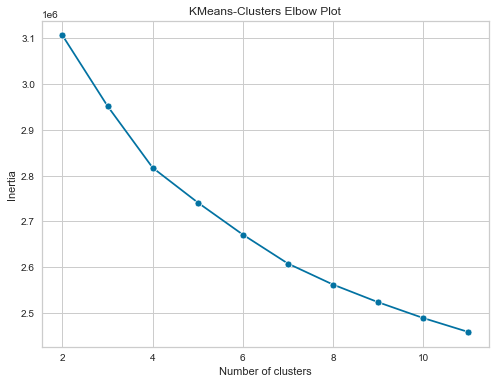

In [60]:
#Elbow Plot to Find Correct K-Value

plt.figure(figsize=(8,6))

sns.lineplot(x=num_clusters, y=inertia, marker = 'o')
plt.xlabel("Number of clusters");
plt.ylabel("Inertia");
plt.title('KMeans-Clusters Elbow Plot')
plt.show()

- No clear elbow to be found maybe 4? or 8

In [65]:
# Evaluate silhouette score.
# Writing a function to return a list of each k-value's score.

def kmeans_silhouette(num_clusters, x_vals):
    silhouette_list = []
    for num in num_clusters:
        kmeans = KMeans(n_clusters=num, random_state=42)
        kmeans.fit(x_vals)
        silhouette_list.append(silhouette_score(x_vals, kmeans.labels_))
    return silhouette_list

In [66]:
#Evaluating Silhouette Score

sil_score = kmeans_silhouette(num_clusters, x_vals=scaled_data)

C:\Users\qnpea\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\qnpea\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\qnpea\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\qnpea\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

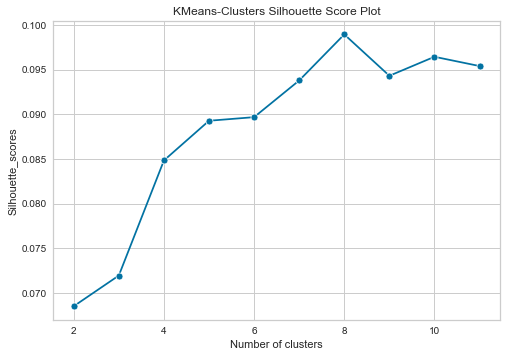

In [67]:
#Creating Plot

sns.lineplot(x=num_clusters, y=sil_score, marker = 'o')
plt.xlabel("Number of clusters");
plt.ylabel("Silhouette_scores");
plt.title('KMeans-Clusters Silhouette Score Plot')
plt.show()

- Silhouette score suggests using K = 8
- 8 still has a very low silhouette score, so clusters are poorly defined

In [69]:
# Now can apply K-means using 8 clusters
kmeans = KMeans(n_clusters=8, random_state = 42)
kmeans.fit(scaled_data)

# Get cluster labels
labels = kmeans.labels_

In [71]:
print(np.unique(kmeans.labels_))

[0 1 2 3 4 5 6 7]


In [72]:
df_subset['KMeans_Cluster'] = labels

In [78]:
df_subset.groupby('KMeans_Cluster')['NumberLetterRatio'].describe()

,count,mean,std,min,25%,50%,75%,max
KMeans_Cluster,,,,,,,,
0,950.0,0.381659,0.214741,0.140086,0.208117,0.320418,0.498417,1.404167
1,1637.0,0.400956,0.172575,0.140417,0.269406,0.378698,0.491124,1.415493
2,1245.0,0.224417,0.073228,0.140039,0.171598,0.199640,0.262069,0.818578
3,933.0,0.324520,0.180985,0.140209,0.186755,0.267327,0.417293,2.103448
4,1486.0,0.295537,0.088005,0.142686,0.232652,0.287500,0.341282,0.854037
5,726.0,0.397939,0.186475,0.140721,0.251251,0.371799,0.494874,1.204762
6,2711.0,0.255897,0.154618,0.140083,0.166800,0.207332,0.282630,1.753191
7,1349.0,0.246684,0.082633,0.140167,0.183333,0.226471,0.287611,0.570787


In [84]:
df_subset.groupby(['KMeans_Cluster', 'Year'])['Year'].describe()

count unique   top freq
KMeans_Cluster Year                        
0              2001    24      1  2001   24
               2002    38      1  2002   38
               2003    38      1  2003   38
               2004    45      1  2004   45
               2005    36      1  2005   36
...                   ...    ...   ...  ...
7              2014   107      1  2014  107
               2015   112      1  2015  112
               2016   116      1  2016  116
               2017   128      1  2017  128
               2018   142      1  2018  142

[144 rows x 4 columns]

In [88]:
df_subset[(df_subset['KMeans_Cluster'] == 7)].groupby('Filing').describe()

Page_Number                                            \
                            count  mean       std   min    25%   50%    75%   
Filing                                                                        
AAPL_10-KA_2009-09-26         1.0  25.0       NaN  25.0  25.00  25.0  25.00   
AAPL_10-K_2002-09-28          1.0  33.0       NaN  33.0  33.00  33.0  33.00   
AAPL_10-K_2004-09-25          1.0  63.0       NaN  63.0  63.00  63.0  63.00   
AAPL_10-K_2006-09-30          2.0  46.5  0.707107  46.0  46.25  46.5  46.75   
AAPL_10-K_2007-09-29          1.0  59.0       NaN  59.0  59.00  59.0  59.00   
...                           ...   ...       ...   ...    ...   ...    ...   
XOM_10-Q_2017-06-30           2.0   4.5  2.121320   3.0   3.75   4.5   5.25   
XOM_10-Q_2017-09-30           2.0   4.5  2.121320   3.0   3.75   4.5   5.25   
XOM_10-Q_2018-03-31           1.0   6.0       NaN   6.0   6.00   6.0   6.00   
XOM_10-Q_2018-06-30           2.0   4.5  2.121320   3.0   3.75   4.5   5.25   
XOM_10-Q_2018-09-30           2.0   4.5  2.121320   3.0   3.75   4.5   5.25   

                            NumberLetterRatio            ... Condensed       \
                        max             count      mean  ...       75%  max   
Filing                                                   ...                  
AAPL_10-KA_2009-09-26  25.0               1.0  0.155354  ...       0.0  0.0   
AAPL_10-K_2002-09-28   33.0               1.0  0.246851  ...       0.0  0.0   
AAPL_10-K_2004-09-25   63.0               1.0  0.159341  ...       0.0  0.0   
AAPL_10-K_2006-09-30   47.0               2.0  0.179474  ...       0.0  0.0   
AAPL_10-K_2007-09-29   59.0               1.0  0.154286  ...       0.0  0.0   
...                     ...               ...       ...  ...       ...  ...   
XOM_10-Q_2017-06-30     6.0               2.0  0.248482  ...       1.0  1.0   
XOM_10-Q_2017-09-30     6.0               2.0  0.261779  ...       1.0  1.0   
XOM_10-Q_2018-03-31     6.0               1.0  0.472803  ...       1.0  1.0   
XOM_10-Q_2018-06-30     6.0               2.0  0.355215  ...       1.0  1.0   
XOM_10-Q_2018-09-30     6.0               2.0  0.365638  ...       1.0  1.0   

                      KMeans_Cluster                                     
                               count mean  std  min  25%  50%  75%  max  
Filing                                                                   
AAPL_10-KA_2009-09-26            1.0  7.0  NaN  7.0  7.0  7.0  7.0  7.0  
AAPL_10-K_2002-09-28             1.0  7.0  NaN  7.0  7.0  7.0  7.0  7.0  
AAPL_10-K_2004-09-25             1.0  7.0  NaN  7.0  7.0  7.0  7.0  7.0  
AAPL_10-K_2006-09-30             2.0  7.0  0.0  7.0  7.0  7.0  7.0  7.0  
AAPL_10-K_2007-09-29             1.0  7.0  NaN  7.0  7.0  7.0  7.0  7.0  
...                              ...  ...  ...  ...  ...  ...  ...  ...  
XOM_10-Q_2017-06-30              2.0  7.0  0.0  7.0  7.0  7.0  7.0  7.0  
XOM_10-Q_2017-09-30              2.0  7.0  0.0  7.0  7.0  7.0  7.0  7.0  
XOM_10-Q_2018-03-31              1.0  7.0  NaN  7.0  7.0  7.0  7.0  7.0  
XOM_10-Q_2018-06-30              2.0  7.0  0.0  7.0  7.0  7.0  7.0  7.0  
XOM_10-Q_2018-09-30              2.0  7.0  0.0  7.0  7.0  7.0  7.0  7.0  

[923 rows x 648 columns]

# To be continued...